## Imports

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

In [41]:
# Load the image
image = cv2.imread('calib-object.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [42]:
def detect_corners(gray, pattern_size):
    # Get the image dimensions
    height, width = gray.shape

    # Define the pattern size for left and right halves
    # pattern_size = (6, 8)

    # Split the image into left and right halves
    left_half = gray[:, :width//2]
    right_half = gray[:, width//2:]

    # Find chessboard corners on the left half
    ret_left, corners_left = cv2.findChessboardCorners(left_half, pattern_size, 
                                                        flags=cv2.CALIB_CB_ADAPTIVE_THRESH | cv2.CALIB_CB_FAST_CHECK | cv2.CALIB_CB_NORMALIZE_IMAGE)

    # Find chessboard corners on the right half
    ret_right, corners_right = cv2.findChessboardCorners(right_half, pattern_size, 
                                                        flags=cv2.CALIB_CB_ADAPTIVE_THRESH | cv2.CALIB_CB_FAST_CHECK | cv2.CALIB_CB_NORMALIZE_IMAGE)

    # Draw corners on the left half
    if ret_left:
        # corners_left = cv2.cornerSubPix(left_half, corners_left, (11, 11), (-1, -1), (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
        left_marked = cv2.drawChessboardCorners(left_half, pattern_size, corners_left, ret_left)
    else:
        print("Chessboard corners not found on the left half")

    # Draw corners on the right half
    if ret_right:
        # corners_right = cv2.cornerSubPix(right_half, corners_right, (11, 11), (-1, -1), (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001))
        # corners_right[:, :, 0] += width//2  # Adjust x-coordinates for the right half
        right_marked = cv2.drawChessboardCorners(right_half, pattern_size, corners_right, ret_right)
    else:
        print("Chessboard corners not found on the right half")

    # Concatenate left and right halves
    # result_image = np.concatenate((left_half, right_half), axis=1)
    result_image = cv2.hconcat([left_marked, right_marked])
    
    return result_image

In [43]:
img_with_corners = detect_corners(gray, (6, 8))
cv2.imwrite('calib-object_corners.jpg', img_with_corners)

True

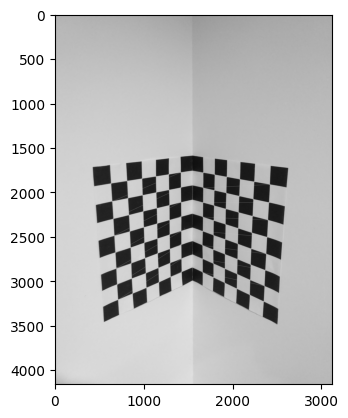

In [44]:
plt.imshow(cv2.cvtColor(img_with_corners, cv2.COLOR_BGR2RGB))
plt.show()

In [9]:
cv2.namedWindow("output", cv2.WINDOW_NORMAL)
imS = cv2.resize(img_with_corners, (540, 540))
cv2.imshow("output", imS)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [5]:
img_with_corners = detect_corners(gray, (6, 8))
cv2.imshow('img_with_corners', img_with_corners)
cv2.waitKey(0)
cv2.destroyAllWindows()
# plt.imshow(img_with_corners, cmap='gray')

### 1.2

* Assume world origin at top middle of the chess board pattern.
* Consider the following world points:

In [61]:
l = 2
world_points_calib1 = np.array([
        [0, 0, 0],
        [0, l, 2*l],
        [0, 2*l, 4*l],
        [0, 3*l, 6*l],
        [2*l, l, 0],
        [4*l, 2*l, 0],
        [6*l, 3*l, 0],
        [0, 3*l, l],
        [0, 4*l, 3*l],
        [0, 5*l, 5*l],
        [l, 3*l, 0],
        [3*l, 4*l, 0],
        [5*l, 5*l, 0],
        [0, 6*l, 0],
        [0, 7*l, 2*l],
        [0, 8*l, 4*l],
        [2*l, 7*l, 0],
        [4*l, 8*l, 0],
        [0, 7*l, 6*l],
        [6*l, 7*l, 0],
    ])

* We choose the corresponding image points on the given image.

In [69]:
def annotateImage(img_path, annotated_img_path):
    img = cv2.imread(img_path, -1)
    total_img_points = []

    def highlight_pixel(event, x, y, flags, param):
        if event == cv2.EVENT_FLAG_RBUTTON:
            # Highlight the pixel at (x, y)
            cv2.circle(img, (x, y), 5, (0, 0, 255), -1)

            # Annotate the pixel at (x, y)
            cv2.putText(img, "({}, {})".format(x, y), (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

            total_img_points.append(np.array([x, y]))
        
    cv2.namedWindow("Image", cv2.WINDOW_NORMAL)
    cv2.setMouseCallback("Image", highlight_pixel)

    while True:
        cv2.imshow("Image", img)
        key = cv2.waitKey(1) & 0xFF

        if key == ord("r"):
            img = cv2.imread(img_path, -1)
            total_img_points = []

        elif key == ord("q"):
            break

    cv2.destroyAllWindows()
    cv2.imwrite(annotated_img_path, img)

    return np.array(total_img_points)

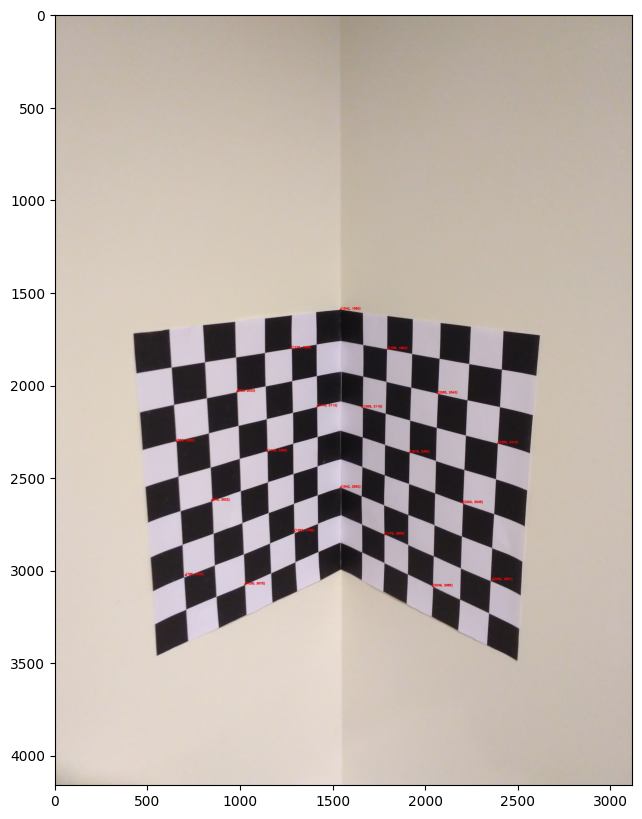

In [70]:
img_points_calib1 = annotateImage('calib-object.jpg', 'calib-object-annotated.jpg')
annotated_img1 = cv2.imread('calib-object-annotated.jpg', -1)
annotated_img1 = cv2.cvtColor(annotated_img1, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(annotated_img1)
plt.show()

* Now that we have many image point, world point pair, we can estimate the projection matrix.

In [71]:
def estimateProjMat(img_points, world_points):   
    # Convert to homogeneous coordinates
    img_points = np.append(img_points, [[1] for i in range(img_points.shape[0])], axis=1)
    world_points = np.append(world_points, [[1] for i in range(world_points.shape[0])], axis=1)
    
    n = img_points.shape[0]
    A = np.zeros((2*n, 12))
    for i in range(n):
        A[2*i, 0:4] = -world_points[i]
        A[2*i+1, 4:8] = -world_points[i]
        A[2*i, 8:12] = img_points[i, 0] * world_points[i]
        A[2*i+1, 8:12] = img_points[i, 1] * world_points[i]
    u, s, vh = np.linalg.svd(A)
    P = vh[-1].reshape(3, 4)
    return P

* The projection matrix can then be decomposed into intrinsic and extrinsic matrix using QR decomposition.

In [72]:
def estimateParameters(P):
    try:
        # Estimate projection center C
        C = np.array(np.dot(-np.linalg.inv(P[:, 0:3]), P[:, 3]))

        # Perform QR decomposition of P
        Q, R = np.linalg.qr(np.linalg.inv(P[:, 0:3]))

        # Estimate Calibration matrix K
        K = np.linalg.inv(R)
        K = K / K[2, 2]

        # Estimate rotation matrix R
        R = np.transpose(Q)
        
        return C, K, R  

    except np.linalg.LinAlgError:
        print('Error: Singular matrix')
        print('The Projection matrix is not invertible')
        return None, None, None

In [73]:
def calibrateCamera(img_points, world_points):
    # Convert to homogeneous coordinates
    img_points = np.append(img_points, [[1] for i in range(img_points.shape[0])], axis=1)
    world_points = np.append(world_points, [[1] for i in range(world_points.shape[0])], axis=1)
    
    n = img_points.shape[0]
    A = np.zeros((2*n, 12))
    for i in range(n):
        A[2*i, 0:4] = -world_points[i]
        A[2*i+1, 4:8] = -world_points[i]
        A[2*i, 8:12] = img_points[i, 0] * world_points[i]
        A[2*i+1, 8:12] = img_points[i, 1] * world_points[i]
    u, s, vh = np.linalg.svd(A)
    P = vh[-1].reshape(3, 4)

    # Estimate projection center C
    C = np.array(np.dot(-np.linalg.inv(P[:, 0:3]), P[:, 3]))

    # Perform QR decomposition of P
    Q, R = np.linalg.qr(np.linalg.inv(P[:, 0:3]))

    # Estimate Calibration matrix K
    K = np.linalg.inv(R)
    K = K / K[2, 2]

    # Estimate rotation matrix R
    R = np.transpose(Q)
    
    return P, C, K, R

In [74]:
P, C, K, R = calibrateCamera(img_points_calib1, world_points_calib1)
print('Estimated Projection Matrix:')
print(tabulate(P, tablefmt="rounded_outline"))
# print('\nEstimated Projection Center:')
# print(tabulate(C, tablefmt="plain"))
print('\nEstimated Calibration Matrix:')
print(tabulate(K, tablefmt="rounded"))
print('\nEstimated Rotation Matrix:')
print(tabulate(R, tablefmt="rounded"))

Estimated Projection Matrix:
╭──────────────┬─────────────┬──────────────┬─────────────╮
│ -0.0386993   │ 0.00374944  │  0.0153209   │ 0.694105    │
│ -0.00735224  │ 0.0420795   │ -0.00823584  │ 0.717341    │
│ -6.80878e-06 │ 2.33771e-06 │ -7.37574e-06 │ 0.000451134 │
╰──────────────┴─────────────┴──────────────┴─────────────╯

Estimated Calibration Matrix:
--------  ----------  -------
-3767.35     6.35274  1499.23
    0     3733.49     1969.15
    0        0           1
--------  ----------  -------

Estimated Rotation Matrix:
---------  -----------  ---------
-0.734039   0.00465904   0.679091
-0.157363  -0.973926    -0.163414
 0.660623  -0.226817     0.715633
---------  -----------  ---------


In [75]:
P

array([[-3.86993017e-02,  3.74943696e-03,  1.53208557e-02,
         6.94105405e-01],
       [-7.35223856e-03,  4.20795462e-02, -8.23583574e-03,
         7.17341264e-01],
       [-6.80877755e-06,  2.33770719e-06, -7.37574414e-06,
         4.51133712e-04]])

### 1.3

* The world points to compute the image of the wireframe are:

In [76]:
world_points_1 = np.array([
    [7*l, 0, 0],
    [0, 0, 0],
    [0, 0, 7*l],
    [0, 9*l, 7*l],
    [0, 9*l, 0],
    [7*l, 9*l, 0],
])
world_points_1 = np.append(world_points_1, [[1] for i in range(world_points_1.shape[0])], axis=1)
print(world_points_1)

[[14  0  0  1]
 [ 0  0  0  1]
 [ 0  0 14  1]
 [ 0 18 14  1]
 [ 0 18  0  1]
 [14 18  0  1]]


* Computing the image points for these world points using the projection matrix.

In [77]:
image_points_1 = np.array(np.dot(P, world_points_1.T).T)
image_points_1 = image_points_1 / image_points_1[:, 2].reshape(-1, 1)
image_points_1 = image_points_1[:, 0:2]
image_points_1 = np.array(image_points_1, dtype=int)
print(image_points_1)

[[ 428 1726]
 [1538 1590]
 [2611 1730]
 [2503 3486]
 [1544 2990]
 [ 552 3447]]


In [78]:
image_points_1 = image_points_1[:, :2].reshape(-1, 1, 2)
print(image_points_1)

[[[ 428 1726]]

 [[1538 1590]]

 [[2611 1730]]

 [[2503 3486]]

 [[1544 2990]]

 [[ 552 3447]]]


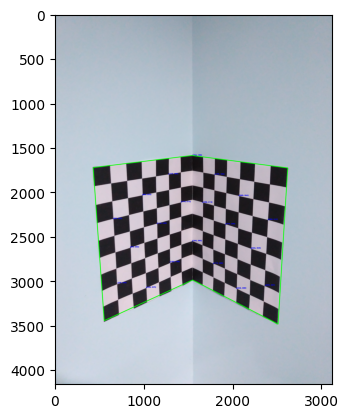

In [79]:
wireframe = cv2.polylines(annotated_img1, [image_points_1], True, (0, 255, 0), 8)
cv2.imwrite('calib-object_wireframe.jpg', wireframe)
plt.imshow(cv2.cvtColor(wireframe, cv2.COLOR_BGR2RGB))
plt.show()

### 1.4

In [18]:
# Tilt (around x-axis)
tilt = np.arctan2(R[2, 1], R[2, 2])

# Pan (around y-axis)
pan = np.arctan2(-R[2, 0], np.sqrt(R[2, 1]**2 + R[2, 2]**2))

# Roll (around z-axis)
roll = np.arctan2(R[1, 0], R[0, 0])

# Convert angles from radians to degrees
tilt_degrees = np.degrees(tilt)
pan_degrees = np.degrees(pan)
roll_degrees = np.degrees(roll)

print("Tilt:", tilt_degrees, "degrees")
print("Pan:", pan_degrees, "degrees")
print("Roll:", roll_degrees, "degrees")

Tilt: -17.578851038001563 degrees
Pan: -42.59145369738033 degrees
Roll: -168.0743806002955 degrees


## 2. OpenCV Calibration

### 2.1

* We use the same world points and image points as in question 1.
* We first use coplanar points to get an initial guess for intrinsic matrix.

In [93]:
indices = [0, 1, 2, 3, 7, 8, 9, 13, 14, 15, 18]
# get world_points_calib1 from these indices
coplanar_world_points_1 = world_points_calib1[indices].astype(np.float32)
print(coplanar_world_points_1)

[[ 0.  0.  0.]
 [ 0.  2.  4.]
 [ 0.  4.  8.]
 [ 0.  6. 12.]
 [ 0.  6.  2.]
 [ 0.  8.  6.]
 [ 0. 10. 10.]
 [ 0. 12.  0.]
 [ 0. 14.  4.]
 [ 0. 16.  8.]
 [ 0. 14. 12.]]


* The corresponding image points are:

In [94]:
coplanar_image_points_1 = img_points_calib1[indices].astype(np.float32)
print(coplanar_image_points_1)

[[1542. 1590.]
 [1795. 1803.]
 [2065. 2043.]
 [2392. 2312.]
 [1659. 2119.]
 [1915. 2362.]
 [2202. 2635.]
 [1542. 2552.]
 [1779. 2805.]
 [2039. 3085.]
 [2362. 3051.]]


* Initial Estimate of Intrinsic Matrix

In [99]:
ret, camera_matrix, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera([coplanar_world_points_1], [coplanar_image_points_1], image.shape[:2], None, None, flags=cv2.CALIB_ZERO_TANGENT_DIST)

error: OpenCV(4.7.0) /io/opencv/modules/calib3d/src/calibration.cpp:1575: error: (-5:Bad argument) For non-planar calibration rigs the initial intrinsic matrix must be specified in function 'cvCalibrateCamera2Internal'


### 2.2

In [118]:
image2 = cv2.imread('assign1.jpg')

* Assuming the world origin at the top left of the chess board pattern, we can use the following world points:

In [100]:
l = 2
world_points_calib2 = np.array([
    [0, 0, 0],
    [2*l, 0, 0],
    [4*l, 0, 0],
    [6*l, 0, 0],
    [0, 2*l, 0],
    [0, 4*l, 0],
    [0, 6*l, 0],
    [l, l, 0],
    [3*l, l, 0],
    [5*l, l, 0],
    [l, 3*l, 0],
    [l, 5*l, 0],
    [2*l, 2*l, 0],
    [4*l, 2*l, 0],
    [6*l, 2*l, 0],
    [2*l, 4*l, 0],
    [2*l, 6*l, 0],
    [3*l, 3*l, 0],
    [5*l, 3*l, 0],
    [3*l, 5*l, 0]
])

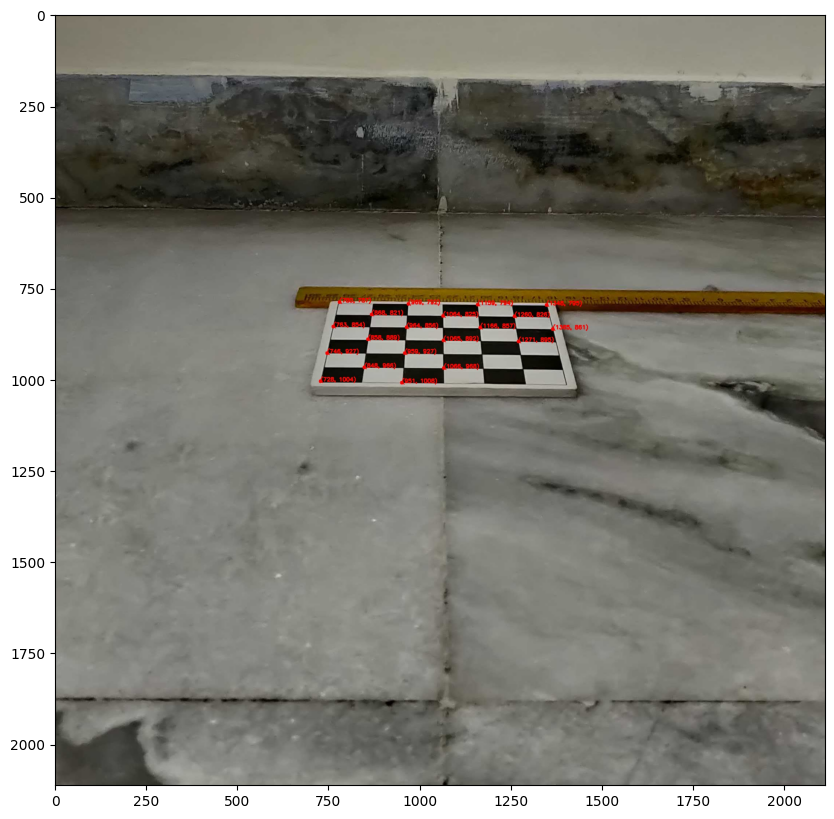

In [101]:
img_points_calib2 = annotateImage('assign1.jpg', 'assign1-annotated.jpg')
annotated_img2 = cv2.imread('assign1-annotated.jpg', -1)
annotated_img2 = cv2.cvtColor(annotated_img2, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10, 10))
plt.imshow(annotated_img2)
plt.show()

In [103]:
world_points_calib2 = np.array(world_points_calib2, dtype=np.float32)
img_points_calib2 = np.array(img_points_calib2, dtype=np.float32)

print(world_points_calib2)
print(img_points_calib2)

[[ 0.  0.  0.]
 [ 4.  0.  0.]
 [ 8.  0.  0.]
 [12.  0.  0.]
 [ 0.  4.  0.]
 [ 0.  8.  0.]
 [ 0. 12.  0.]
 [ 2.  2.  0.]
 [ 6.  2.  0.]
 [10.  2.  0.]
 [ 2.  6.  0.]
 [ 2. 10.  0.]
 [ 4.  4.  0.]
 [ 8.  4.  0.]
 [12.  4.  0.]
 [ 4.  8.  0.]
 [ 4. 12.  0.]
 [ 6.  6.  0.]
 [10.  6.  0.]
 [ 6. 10.  0.]]
[[ 780.  787.]
 [ 969.  792.]
 [1159.  794.]
 [1348.  795.]
 [ 763.  854.]
 [ 746.  927.]
 [ 728. 1004.]
 [ 868.  821.]
 [1064.  825.]
 [1260.  826.]
 [ 858.  889.]
 [ 848.  966.]
 [ 964.  856.]
 [1166.  857.]
 [1365.  861.]
 [ 959.  927.]
 [ 951. 1008.]
 [1065.  892.]
 [1271.  895.]
 [1066.  968.]]


In [184]:
# camera_matrix = np.zeros((3, 3), dtype=np.float32)
# dist_coeffs = np.zeros((4, 1), dtype=np.float32)

ret, camera_matrix, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera([world_points_calib2], [img_points_calib2], image2.shape[1::-1], None, None)

print("Camera Matrix:")
print(camera_matrix)
print("\nDistortion Coefficients:")
print(dist_coeffs)
print("\nRotation Vectors:")
print(rvecs)
print("\nTranslation Vectors:")
print(tvecs)

Camera Matrix:
[[3.13274656e+03 0.00000000e+00 1.08846097e+03]
 [0.00000000e+00 2.47675572e+03 1.04297850e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Distortion Coefficients:
[[-6.32506598e+00  4.68567030e+02 -6.22118656e-02 -6.83234240e-03
  -1.15420575e+04]]

Rotation Vectors:
(array([[-1.05874229],
       [-0.02277966],
       [ 0.00180696]]),)

Translation Vectors:
(array([[-6.50313798],
       [-6.68075839],
       [64.68938395]]),)


In [186]:
# Rotation Matrix
R2, _ = cv2.Rodrigues(rvecs[0])
print(R2)

C = tvecs[0]

P2 = np.dot(camera_matrix, np.c_[R2, C])
print(P2)

[[ 0.99976242  0.00948557 -0.01962483]
 [ 0.01246089  0.48999     0.87163899]
 [ 0.01788396 -0.87167645  0.48975538]]
[[ 3.15146826e+03 -9.19069912e+02  4.71600010e+02  5.00391865e+04]
 [ 4.95151705e+01  3.04445731e+02  2.66964119e+03  5.09230299e+04]
 [ 1.78839598e-02 -8.71676447e-01  4.89755384e-01  6.46893840e+01]]


* World points to draw the wireframe:

In [187]:
world_points_2 = np.array([
    [0, 0, 0],
    [6*l, 0, 0],
    [6*l, 6*l, 0],
    [0, 6*l, 0],
], dtype=np.float32)
world_points_2 = np.append(world_points_2, [[1] for i in range(world_points_2.shape[0])], axis=1)
print(world_points_2)

[[ 0.  0.  0.  1.]
 [12.  0.  0.  1.]
 [12. 12.  0.  1.]
 [ 0. 12.  0.  1.]]


In [188]:
image_points_2 = np.array(np.dot(P2, world_points_2.T).T)
image_points_2 = image_points_2 / image_points_2[:, 2].reshape(-1, 1)
image_points_2 = image_points_2[:, 0:2]
image_points_2 = np.array(image_points_2, dtype=int)
print(image_points_2)

[[ 773  787]
 [1353  793]
 [1411 1013]
 [ 719 1006]]


In [189]:
image_points_2 = image_points_2[:, :2].reshape(-1, 1, 2)
print(image_points_2)

[[[ 773  787]]

 [[1353  793]]

 [[1411 1013]]

 [[ 719 1006]]]


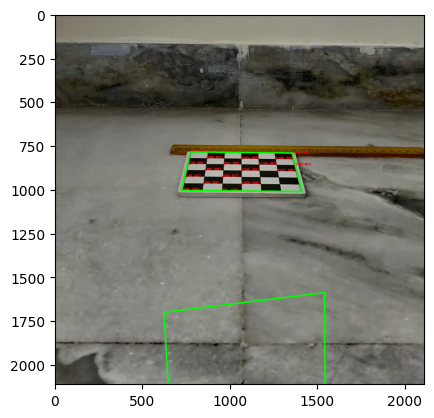

In [191]:
wireframe2 = cv2.polylines(annotated_img2, [image_points_2], True, (0, 255, 0), 8)
cv2.imwrite('assign1_wireframe.jpg', wireframe2)
# plt.imshow(cv2.cvtColor(wireframe2, cv2.COLOR_BGR2RGB))
plt.imshow(wireframe2)
plt.show()

## 3. Moving the Chessboard

### 3.1

* We shift all the world points by 10cm to the right.

In [192]:
world_points_3 = np.array([
    [10, 0, 0],
    [10+6*l, 0, 0],
    [10+6*l, 6*l, 0],
    [10, 6*l, 0],
], dtype=np.float32)
world_points_3 = np.append(world_points_3, [[1] for i in range(world_points_3.shape[0])], axis=1)
print(world_points_3)

[[10.  0.  0.  1.]
 [22.  0.  0.  1.]
 [22. 12.  0.  1.]
 [10. 12.  0.  1.]]


In [193]:
image_points_3 = np.array(np.dot(P2, world_points_3.T).T)
image_points_3 = image_points_3 / image_points_3[:, 2].reshape(-1, 1)
image_points_3 = image_points_3[:, 0:2]
image_points_3 = np.array(image_points_3, dtype=int)
print(image_points_3)
image_points_3 = image_points_3[:, :2].reshape(-1, 1, 2)
print(image_points_3)

[[1257  792]
 [1834  799]
 [1983 1019]
 [1296 1012]]
[[[1257  792]]

 [[1834  799]]

 [[1983 1019]]

 [[1296 1012]]]


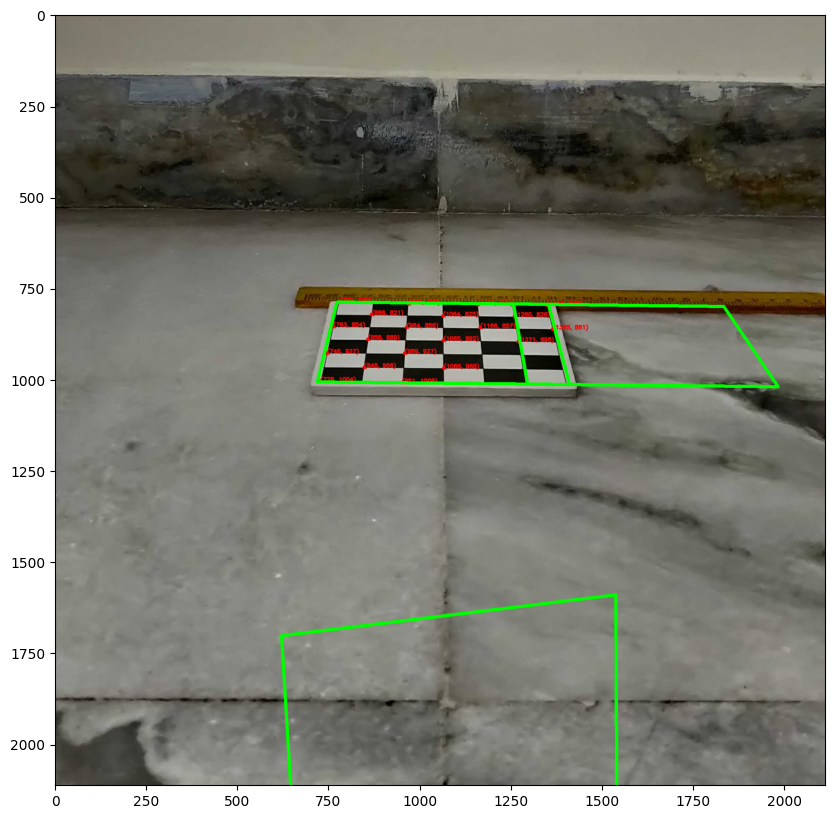

In [200]:
wireframe3 = cv2.polylines(annotated_img2, [image_points_3], True, (0, 255, 0), 8)
cv2.imwrite('assign1_wireframe_10cm.jpg', wireframe3)
plt.figure(figsize=(10,10))
plt.imshow(wireframe3)
plt.show()

### 3.2

* We take a grid of world points (the denser the better) and compute its original image point and the image point after shifting the world points, and copy the pixel values from the original image point to the new image point.

In [202]:
x, y = np.meshgrid(np.linspace(0, 6*l, 1000), np.linspace(0, 6*l, 1000))
grid_world_points = np.dstack([x, y]).reshape(-1, 2)
grid_world_points = np.float32(np.array([(np.array([x,y,0,1])) for x,y in grid_world_points]))
print(grid_world_points)

[[ 0.          0.          0.          1.        ]
 [ 0.01201201  0.          0.          1.        ]
 [ 0.02402402  0.          0.          1.        ]
 ...
 [11.975976   12.          0.          1.        ]
 [11.9879875  12.          0.          1.        ]
 [12.         12.          0.          1.        ]]


In [203]:
original_image_points = np.dot(P2, grid_world_points.T).T
original_image_points = np.int32( original_image_points[:, :2] / original_image_points[:, None, 2])
print(original_image_points)

[[ 773  787]
 [ 774  787]
 [ 774  787]
 ...
 [1409 1013]
 [1410 1013]
 [1411 1013]]


In [205]:
new_image_points = np.dot(P2, (grid_world_points + np.array([10, 0, 0, 0])).T).T
new_image_points = np.int32(new_image_points[:, :2] / new_image_points[:, None, 2])
print(new_image_points)

[[1257  792]
 [1257  792]
 [1258  792]
 ...
 [1982 1019]
 [1982 1019]
 [1983 1019]]


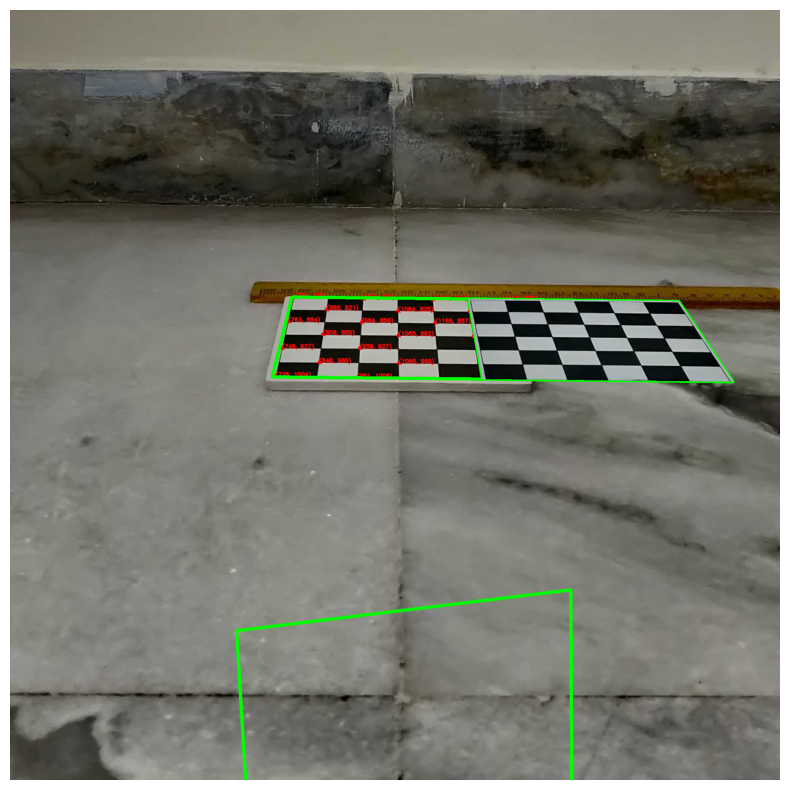

In [207]:
wireframe4 = np.copy(wireframe3)
assign1_modified =  np.copy(image2)
wireframe4[new_image_points[:, 1], new_image_points[:, 0], :] = assign1_modified[original_image_points[:, 1], original_image_points[:, 0], :]
cv2.imwrite("assign1_moved_chessboard.jpg", wireframe4)
plt.figure(figsize=(10,10))
plt.imshow(wireframe4)
plt.axis('off')  
plt.show()